In [1]:
%pwd

'C:\\Users\\User\\Metric_Int'

In [2]:
pip install --upgrade google-cloud-storage

Note: you may need to restart the kernel to use updated packages.


In [29]:
pip install --upgrade google-cloud-bigquery

In [1]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot
from pandas import Series, DataFrame as plt
import seaborn as sns
import numpy as np

In [2]:
import os
from google.cloud import bigquery 


In [3]:
from scipy.stats import pearsonr
from scipy.stats import ttest_ind #Independent Sample T-test
from scipy.stats import f_oneway #One-Way ANOVA

import scipy.stats as stats

In [4]:
import io
import matplotlib.pyplot as plt
import math
%matplotlib inline

import plotly.express as px
import matplotlib.ticker as mtick

In [110]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"C:\Users\User\Metric_Int\bigquery-demo-351018-b30bfa9122f7.json"
SERVICE_ACCOUNT_JSON=os.environ['GOOGLE_APPLICATION_CREDENTIALS']
client=bigquery.Client.from_service_account_json(SERVICE_ACCOUNT_JSON)

# note: Use this to connect with Big Query database

In [6]:
%load_ext google.cloud.bigquery

In [7]:
client = bigquery.Client()


query = """

with Tables as (
 SELECT *,
FROM 
  `bigquery-public-data.crypto_ethereum.balances` 

ORDER BY address), 
 


Total_S as (
SELECT from_address,
SUM(value/POWER(10,18)) Sum_sent,
count(from_address) number_transactions_sent
 FROM `bigquery-public-data.crypto_ethereum.transactions`
where from_address is not null
GROUP BY from_address
ORDER BY from_address
),

Average_S as (
SELECT from_address,
Avg(number_transactions_sent) Ave_trans_num_sent,
Avg(Sum_sent) Aver_trans_val_sent
From  (SELECT from_address,
count(from_address) number_transactions_sent,
SUM(value/POWER(10,18)) Sum_sent,
date_trunc(block_timestamp, month) as Mnth
FROM `bigquery-public-data.crypto_ethereum.transactions`
where from_address is not null
GROUP BY from_address, Mnth
)
GROUP BY from_address
ORDER BY from_address
),

Times_S as (SELECT from_address,
STDDEV(Delta) STD_time_sent, Avg(Delta) Ave_time_sent
From  (SELECT from_address, block_timestamp, 
  timestamp_diff(block_timestamp, lag(block_timestamp) over(partition by from_address order by block_timestamp),  MINUTE)
  Delta
  FROM `bigquery-public-data.crypto_ethereum.transactions`
ORDER BY from_address, block_timestamp
)
GROUP BY from_address
ORDER BY from_address
),

Months_S as (SELECT from_address,
count(Mnth) as Active_months_sent
FROM (
SELECT from_address,
count(from_address) number_transactions_sent,
SUM(value/POWER(10,18)) Sum_sent,
date_trunc(block_timestamp, month) as Mnth
FROM `bigquery-public-data.crypto_ethereum.transactions`
where from_address is not null
GROUP BY from_address, Mnth
ORDER BY from_address
)
where from_address is not null
GROUP BY from_address
),

Total_R as (
SELECT to_address,
SUM(value/POWER(10,18)) Sum_received,
count(to_address) number_transactions_received
 FROM `bigquery-public-data.crypto_ethereum.transactions`
where to_address is not null
GROUP BY to_address
ORDER BY to_address
),

Average_R as (
SELECT to_address,
Avg(number_transactions_received) Ave_trans_num_received,
Avg(Sum_received) Aver_trans_val_received
From  (SELECT to_address,
count(to_address) number_transactions_received,
SUM(value/POWER(10,18)) Sum_received,
date_trunc(block_timestamp, month) as Mnth
FROM `bigquery-public-data.crypto_ethereum.transactions`
where to_address is not null
GROUP BY to_address, Mnth
)
GROUP BY to_address
ORDER BY to_address
),

Times_R as (SELECT to_address,
STDDEV(Delta) STD_time_received, Avg(Delta) Ave_time_received
From  (SELECT to_address, block_timestamp, 
  timestamp_diff(block_timestamp, lag(block_timestamp) over(partition by to_address order by block_timestamp),  MINUTE)
  Delta
  FROM `bigquery-public-data.crypto_ethereum.transactions`
  where to_address is not null
ORDER BY to_address, block_timestamp
)
GROUP BY to_address
ORDER BY to_address
),

Months_R as (SELECT to_address,
count(Mnth) as Active_months_received
FROM (
SELECT to_address,
count(to_address) number_transactions_received,
SUM(value/POWER(10,18)) Sum_received,
date_trunc(block_timestamp, month) as Mnth
FROM `bigquery-public-data.crypto_ethereum.transactions`
where to_address is not null
GROUP BY to_address, Mnth
ORDER BY to_address
)
where to_address is not null
GROUP BY to_address
)

select 
        tb.address, 
        tb.eth_balance,
       t1.Sum_sent,
       t1.number_transactions_sent,
       a1.Ave_trans_num_sent,
       a1.Aver_trans_val_sent,
       tm1.Ave_time_sent,
       tm1.STD_time_sent,
       m1.Active_months_sent,     
       t2.Sum_received,
       t2.number_transactions_received,
       a2.Ave_trans_num_received,
       a2.Aver_trans_val_received,
       tm2.Ave_time_received,
       tm2.STD_time_received,
       m2.Active_months_received
       
       from Tables tb
left join Total_S    t1 on  tb.address=t1.from_address     
left join Average_S  a1 on tb.address=a1.from_address
left join Times_S    tm1 on tb.address=tm1.from_address
left join Months_S   m1 on tb.address=m1.from_address
left join Total_R    t2 on  tb.address=t2.to_address 
left join Average_R  a2 on tb.address=a2.to_address
left join Times_R    tm2 on tb.address=tm2.to_address
left join Months_R   m2 on tb.address=m2.to_address

LIMIT 1000000;
"""

In [8]:
query_job = client.query(query)

iterator = query_job.result(timeout=300)
rows = list(iterator)

# Transform the rows into a nice pandas dataframe
df = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))

# Look at the first 3
df.head(3)

,address,eth_balance,Sum_sent,number_transactions_sent,Ave_trans_num_sent,Aver_trans_val_sent,Ave_time_sent,STD_time_sent,Active_months_sent,Sum_received,number_transactions_received,Ave_trans_num_received,Aver_trans_val_received,Ave_time_received,STD_time_received,Active_months_received
0,0x6d58318f9fe03d59f13c314a1466ff3cbf468309,2552092107598733712,76.255723,133.0,12.090909,6.932338,6815.121212,28987.286618,11.0,47.046345,45.0,6.428571,6.720906,19269.386364,76265.018159,7.0
1,0x98bd417ace8581c1545af03ba1ae076fc12ae85a,17660338440000000,0.124000,16.0,16.000000,0.124000,482.733333,958.824464,1.0,0.144970,5.0,5.000000,0.144970,1815.750000,1077.419873,1.0
2,0x17f28598eddecd9a4af8ca61aac77d64aea2516d,0,3.240792,24.0,12.000000,1.620396,2379.956522,4219.403776,2.0,3.297072,20.0,10.000000,1.648536,2938.631579,4653.550618,2.0


In [9]:
## Create transaction balance col to understand if the address mostly buys or sells

df['transaction_balance']=df['Ave_trans_num_sent']-df['Ave_trans_num_received']

In [10]:
## classify addresses into 3 groups: buyers, sellers and both

def buyer_seller (transaction_balance):
    if transaction_balance > 0:
        return "Buyer"
    elif transaction_balance < 0:
        return "Seller"
    else: 
        return "Both"

In [11]:
## Create new col

df['buyer_seller']=df.transaction_balance.apply(buyer_seller)

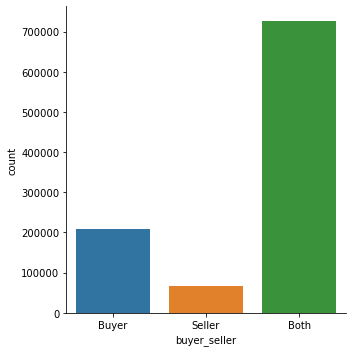

In [12]:
## Just count each category

sns.catplot(x="buyer_seller",kind="count",data=df)

## For Sender category

In [25]:
df['number_transactions_sent'].describe()

count    6.391790e+05
mean     1.360945e+01
std      4.340870e+03
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      3.000000e+00
max      3.459614e+06
Name: number_transactions_sent, dtype: float64

In [71]:
## Create new col which will show if the address is Active or Passive for those who sent transactions

def Activity_sent (number_transactions_sent):
    if number_transactions_sent < 2: #thise who has only one transaction
        return "Very_Passive"
    elif number_transactions_sent >=2 and number_transactions_sent <1000:
        return "Passive"
    else: 
        return "Active"
    
    #note: Importantly, passive group is not increasing after upper bound is as large as 10,000, something is wrong with the 
    #data or the code!!!

In [72]:
df['Activity_sent']=df.number_transactions_sent.apply(Activity_sent)

In [73]:
df['Activity_sent'].value_counts()

Active          361162
Passive         360384
Very_Passive    278454
Name: Activity_sent, dtype: int64

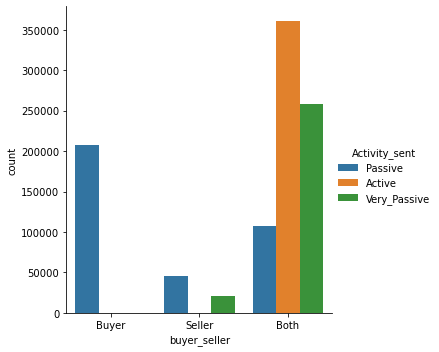

In [74]:
sns.catplot(x="buyer_seller",kind="count",data=df,hue="Activity_sent")

# 
# Distribution of activity level for those who have net receiver position (buyer), net sender position (seller), or zero (both).

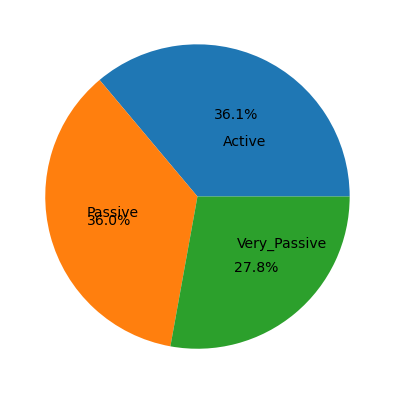

In [75]:
# Percentages of Active, Passive, Very_passive addresses by sent transactions

plt.figure(figsize=(7,7))

df.Activity_sent.value_counts().plot(kind='pie', 
                                        autopct='%.1f%%',
                                        textprops={'fontsize': 14},
                                        labeldistance=0.4)
                                   
plt.ylabel('')

plt.show()

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Ave_time_sent', ylabel='Density'>

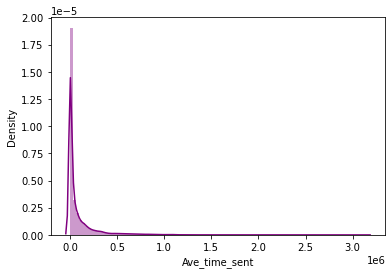

In [76]:
# Average time between transaction is very short for the most of the users of sent addresses

sns.distplot(df['Ave_time_sent'].dropna(),bins=100,color='purple')

## For Buyers category

In [77]:
## Create new col which will show if the address is Active or Passive for those who sent transactions

def Activity_received (number_transactions_received):
    if number_transactions_received < 2:
        return "Very_Passive"
    elif number_transactions_received >=2 and number_transactions_received <1000:
        return "Passive"
    else: 
        return "Active"

In [78]:
df['Activity_received']=df.number_transactions_received.apply(Activity_received)

In [79]:
df['Activity_received'].value_counts()

Very_Passive    443437
Active          315453
Passive         241110
Name: Activity_received, dtype: int64

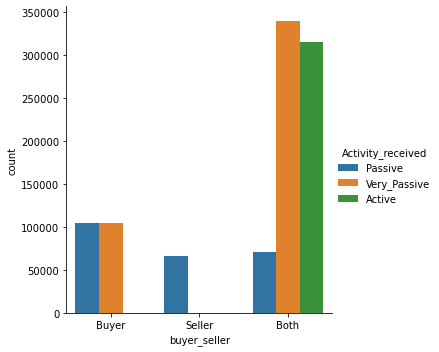

In [80]:
sns.catplot(x="buyer_seller",kind="count",data=df,hue="Activity_received")

# Buyers are mostly passive
# 

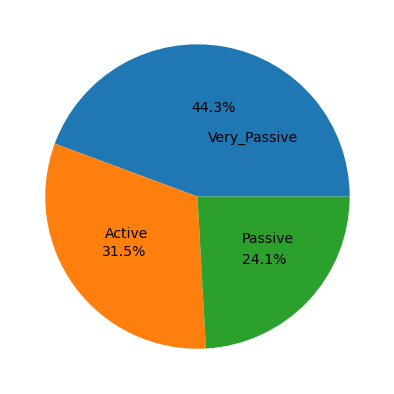

In [81]:
# Percentages of Active, Passive, Very_passive addresses by received transactions

plt.figure(figsize=(7,7))

df.Activity_received.value_counts().plot(kind='pie', 
                                        autopct='%.1f%%',
                                        textprops={'fontsize': 14},
                                        labeldistance=0.4)
                                   
plt.ylabel('')

plt.show()

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Ave_time_received', ylabel='Density'>

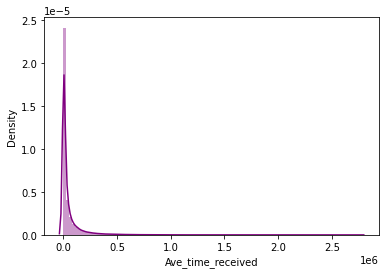

In [82]:
# Average time between transaction is very short for the most of the users of sent addresses as well

sns.distplot(df['Ave_time_received'].dropna(),bins=100,color='purple')

### TESTs for eth balance

In [83]:
## Change eth_balance from object to float

df['eth_balance'] = df['eth_balance'].astype(float)

In [84]:
# Devide by 1mln (very large  numbers and zero numbers in the same column seem to be problematic)

df['eth_balance_mln']=df['eth_balance']/1000000

In [85]:
## Categorize in numeric way so that sending addresses can be used for conducting ANOVA test

def s (Activity_sent):
    if Activity_sent=='Active':
        return 1
    elif Activity_sent=='Passive':
        return 2
    elif Activity_sent=='Very_Passive' :
        return 3
    else:
        return
        
df['Activity_sent_coded'] = df.apply(lambda x: s(x['Activity_sent']),axis=1)

In [86]:
## Categorize in numeric way so that receiving addresses can be used for conducting ANOVA test

def r (Activity_received):
    if Activity_received=='Active':
        return 1
    elif Activity_received=='Passive':
        return 2
    elif Activity_received=='Very_Passive' :
        return 3
    else:
        return
        
df['Activity_received_coded'] = df.apply(lambda x: r(x['Activity_received']),axis=1)

### For sent_addresses

Text(0, 0.5, 'Mean')

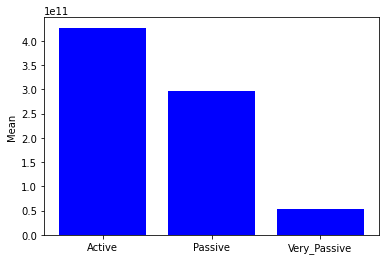

In [87]:
## In the sellers category active addresses have larger eth balance than passive addresses

x1 = df["eth_balance_mln"].groupby(df['Activity_sent']).mean().reset_index()
plt.bar(range(len(x1)), x1['eth_balance_mln'], color="blue")
plt.xticks(range(len(x1)), x1['Activity_sent'])
plt.ylabel('Mean')

Here we have more than two groups, so we use the ANOVA test to compare Active, Passive and Very_passive sent address holders. 

In [88]:
# one way ANOVA

stats.f_oneway(df['eth_balance_mln'].dropna()[df['Activity_sent_coded'] == 1],
               df['eth_balance_mln'].dropna()[df['Activity_sent_coded'] == 2],
               df['eth_balance_mln'].dropna()[df['Activity_sent_coded'] == 3])

F_onewayResult(statistic=6.853120659011877, pvalue=0.0010562042489762392)

Result: The null hypothesis (etherium balace of all groups of senders are the same) is rejected because the p-value is 0,001. Balance for senders is not the same for each category, it depends on how active the sender is.

note: it seems that every time loading the data into data frame it loads different samples, so results change.

#### Tuky for pairwise comparisons of 3 groups: Active, Passive, Very_passive

In [91]:
import statsmodels.stats.multicomp as mc

In [92]:
comp = mc.MultiComparison(df['eth_balance_mln'], df['Activity_sent_coded'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,-129818019187.8119,0.3597,-352484826765.2914,92848788389.6676,False
1,3,-374584752741.7389,0.001,-613085174081.6637,-136084331401.8141,True
2,3,-244766733553.927,0.0428,-483379203223.8058,-6154263884.0482,True


OUTCOME: here we see that group1 and group2 are not different, Avtives and Passives have the same balance. Difference is coming from very passive group, in line with barplot above.

## For received addresses

Text(0, 0.5, 'Mean')

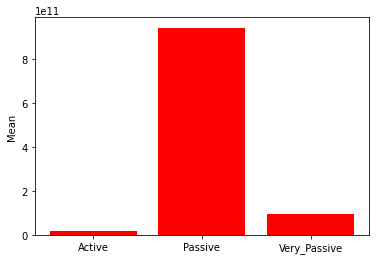

In [93]:
## In the buyers category passive addresses have larger eth balance than active addresses, 
# maybe many people just buy ones to have eth

x1 = df["eth_balance_mln"].groupby(df['Activity_received']).mean().reset_index()
plt.bar(range(len(x1)), x1['eth_balance_mln'], color="red")
plt.xticks(range(len(x1)), x1['Activity_received'])
plt.ylabel('Mean')

In [94]:
stats.f_oneway(df['eth_balance_mln'].dropna()[df['Activity_received_coded'] == 1],
               df['eth_balance_mln'].dropna()[df['Activity_received_coded'] == 2],
               df['eth_balance_mln'].dropna()[df['Activity_received_coded'] == 3])

F_onewayResult(statistic=43.585555037511, pvalue=1.1799373272135511e-19)

Result: The null hypothesis (etherium balace of all groups of receivers are the same) is rejected because the p-value is 0,00. Balance for receivers is not the same for each category, it depends on how active the sender is.

In [95]:
comp = mc.MultiComparison(df['eth_balance_mln'], df['Activity_received_coded'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,922369755901.2186,0.001,666556221904.5496,1178183289897.8877,True
1,3,77153455610.0223,0.6739,-143112518762.4859,297419429982.5306,False
2,3,-845216300291.1963,0.001,-1084503437980.7017,-605929162601.6909,True


OUTCOME: Here instead balances are larger for those who implement less transactions.

### Difference of Active senders and receivers

In [103]:
df['eth_balance_mln'].dropna()[df['Activity_sent_coded'] == 1].mean()


427228594688.05585

In [102]:
df['eth_balance_mln'].dropna()[df['Activity_received_coded'] == 1].mean()

19534366180.44439

In [96]:
stats.f_oneway(df['eth_balance_mln'].dropna()[df['Activity_sent_coded'] == 1],
               df['eth_balance_mln'].dropna()[df['Activity_received_coded'] == 1])

F_onewayResult(statistic=14.608410116953037, pvalue=0.00013233452672078267)

RESULT: as p-value < 0,05 we reject the null hypothesis that etherium balance for Active Players (senders and receivers) is the same. So If you are Active the eth balance is much larger.

### Difference of Passive senders and receivers

In [104]:
stats.f_oneway(df['eth_balance_mln'].dropna()[df['Activity_sent_coded'] == 2],
               df['eth_balance_mln'].dropna()[df['Activity_received_coded'] == 2])

F_onewayResult(statistic=20.83661549513475, pvalue=5.002741154053843e-06)

RESULT: the same result for Passive players - those who send have much larger eth balance than those who receive.

<AxesSubplot:>

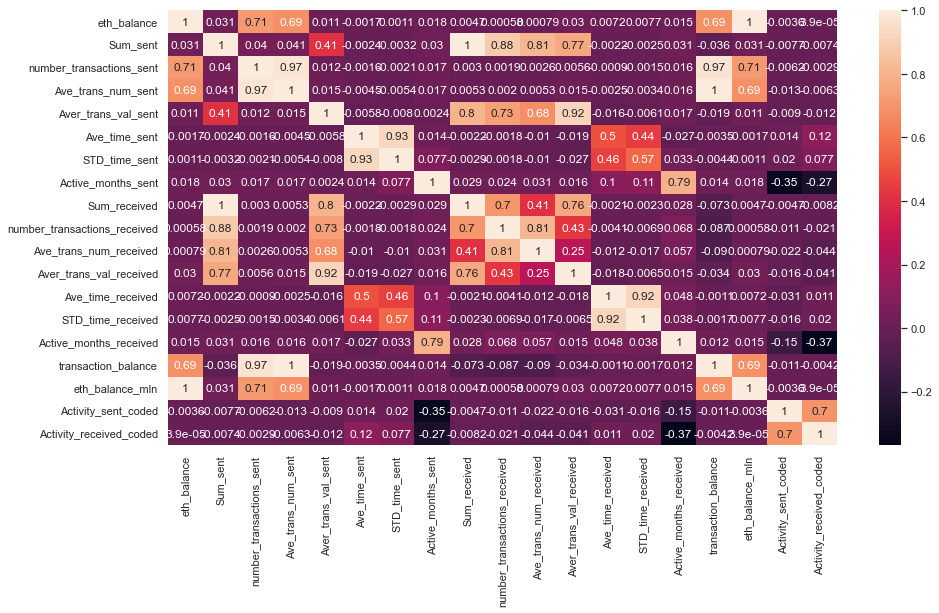

In [105]:
# Correlation matrix

sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(df.corr(),annot=True)

## Regression Model for Sent addresses

In [106]:
df.describe()

,eth_balance,Sum_sent,number_transactions_sent,Ave_trans_num_sent,Aver_trans_val_sent,Ave_time_sent,STD_time_sent,Active_months_sent,Sum_received,number_transactions_received,Ave_trans_num_received,Aver_trans_val_received,Ave_time_received,STD_time_received,Active_months_received,transaction_balance,eth_balance_mln,Activity_sent_coded,Activity_received_coded
count,1.000000e+06,6.391790e+05,6.391790e+05,639179.000000,6.391790e+05,3.607250e+05,2.205290e+05,639179.000000,6.847640e+05,684764.000000,684764.000000,684764.000000,2.413270e+05,1.249580e+05,684764.000000,614521.000000,1.000000e+06,1000000.000000,1000000.000000
mean,2.761396e+17,9.650325e+01,1.360945e+01,2.852769,4.207151e+01,8.847033e+04,7.701291e+04,1.811308,8.214713e+01,7.703121,1.939607,34.986859,5.605684e+04,7.107097e+04,1.516011,1.260355,2.761396e+11,1.917292,2.127984
std,4.035119e+19,2.272184e+04,4.340870e+03,236.468401,4.073576e+03,1.894198e+05,1.417168e+05,2.104669,2.144223e+04,866.281620,43.819194,1039.713134,1.469754e+05,1.435227e+05,1.920957,242.131774,4.035119e+13,0.795472,0.861691
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,1.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,1.000000,-16443.901961,0.000000e+00,1.000000,1.000000
25%,0.000000e+00,4.403458e-03,1.000000e+00,1.000000,2.770820e-03,1.901667e+02,1.183697e+03,1.000000,1.210000e-02,1.000000,1.000000,0.011000,6.500000e+01,4.785759e+03,1.000000,0.000000,0.000000e+00,1.000000,1.000000
50%,0.000000e+00,9.500000e-02,2.000000e+00,1.000000,6.964593e-02,1.479850e+04,2.031730e+04,1.000000,1.000000e-01,1.000000,1.000000,0.086979,9.618000e+03,2.140441e+04,1.000000,0.000000,0.000000e+00,2.000000,2.000000
75%,5.877296e+14,1.186155e+00,3.000000e+00,2.000000,8.500652e-01,8.657650e+04,8.926162e+04,2.000000,1.056472e+00,2.000000,1.500000,0.830000,4.607133e+04,7.100515e+04,1.000000,1.000000,5.877296e+08,3.000000,3.000000
max,1.877598e+22,1.568415e+07,3.459614e+06,182084.947368,3.091982e+06,3.141729e+06,2.285858e+06,60.000000,1.568415e+07,567298.000000,17619.100000,483827.216667,2.760227e+06,1.729727e+06,61.000000,182082.359133,1.877598e+16,3.000000,3.000000


In [107]:
# Import the linear regression from statsmodels
import statsmodels.api as sm

In [108]:
# Prepare target and input variables. 
X_multi=df[['Ave_trans_num_sent','Active_months_sent','eth_balance_mln','Activity_sent_coded']].dropna()
Y_target=df['Aver_trans_val_sent'].dropna()
# Add the costant to our input variables
X_multi=sm.tools.tools.add_constant(X_multi, prepend=True, has_constant='skip')

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [109]:
# OLS Regression
mod = sm.OLS(Y_target, X_multi)
res = mod.fit()
print(res.summary())

                             OLS Regression Results                            
Dep. Variable:     Aver_trans_val_sent   R-squared:                       0.000
Model:                             OLS   Adj. R-squared:                  0.000
Method:                  Least Squares   F-statistic:                     47.23
Date:                 Fri, 27 May 2022   Prob (F-statistic):           9.17e-40
Time:                         20:03:02   Log-Likelihood:            -6.2199e+06
No. Observations:               639179   AIC:                         1.244e+07
Df Residuals:                   639174   BIC:                         1.244e+07
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 22

RESULTS: The dependant variable is Average monthly transactions value, so we are trying to understant how each variable (1.Average monthly transactions, 2.Active months, 3.Etherium balance, 4.Activness) affects it. 
All variables are statistically significant 

note: this description is not true for current data loaded.

Comments: 
1. the base was too big to load it fully, so I limited it to 1 mln rows. 
2. every time when data loaded to Data frame it is different 
3. For Average and STD of time between transactions I got obscure results and could not use them vor further computations.